In [2]:
!pip install statsmodels

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
def stationarity_check(ts):
    result = adfuller(ts)
    print(f"ADF Statistic : {result[0]}")
    print(f"p-value:{result[1]}")
    print(f"Critical values : {result[4]}")

def plot_acf_pacf(ts):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
    plot_acf(ts,ax=ax1,lags=20)
    plot_pacf(ts,ax=ax2,lags=20)
    plt.show()

In [4]:
stock_symbol = "AAPL"
start_date = "2015-01-01"
end_date = "2023-01-01"
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)['Close']

/tmp/ipykernel_7226/1853554278.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed


In [5]:
stock_data

Ticker,AAPL
Date,
2015-01-02,24.237545
2015-01-05,23.554737
2015-01-06,23.556963
2015-01-07,23.887281
2015-01-08,24.805082
...,...
2022-12-23,129.900284
2022-12-27,128.097504
2022-12-28,124.166786


In [6]:
log_returns = stock_data.pct_change().dropna()
log_returns = log_returns.apply(lambda x:np.log(1+x))

In [7]:
# Check stationarity
stationarity_check(log_returns)

# Differencing to make the series stationary
log_returns_diff = log_returns.diff().dropna()

# Check stationarity after differencing
stationarity_check(log_returns_diff)

ADF Statistic : -13.84756715396118
p-value:7.102811663435061e-26
Critical values : {'1%': np.float64(-3.4336173133865064), '5%': np.float64(-2.86298332472282), '10%': np.float64(-2.5675383641200633)}
ADF Statistic : -14.05406898493388
p-value:3.139999133580725e-26
Critical values : {'1%': np.float64(-3.433648628001351), '5%': np.float64(-2.8629971502062155), '10%': np.float64(-2.5675457254979093)}


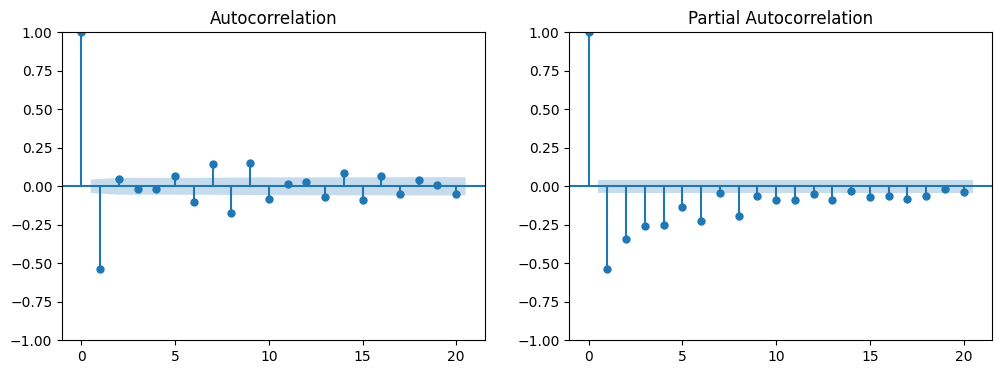

In [8]:
plot_acf_pacf(log_returns_diff)

In [9]:
best_aic = float('inf')
best_bic = float('inf')
best_order = None

for p in range(4):
    for d in range(2):
        for q in range(4):
            arima_model = ARIMA(log_returns,order=(p,d,q))
            arima_results = arima_model.fit()

            current_aic = arima_results.aic
            current_bic = arima_results.bic

            if current_aic<best_aic and current_bic<best_bic:
                best_aic = current_aic
                best_bic = current_bic
                best_order = (p,d,q)
print(f"Best AIC : {best_aic} , Best BIC : {best_bic} , Best order : {best_order}")

/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

Best AIC : -10279.359653922369 , Best BIC : -10262.53750964545 , Best order : (0, 0, 1)


/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [10]:
#import pmdarima as pm
#arima_model = pm.auto_arima(log_returns, seasonal=False, trace=True)

arima_model = ARIMA(log_returns,order=(2,1,4))
arima_results = arima_model.fit()
#arima_results =  arima_model.summary()

/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

In [11]:
residuals = arima_results.resid
stationarity_check(residuals)

ADF Statistic : -44.77333993830058
p-value:0.0
Critical values : {'1%': np.float64(-3.433604305449515), '5%': np.float64(-2.8629775816425003), '10%': np.float64(-2.5675353062242845)}


In [12]:
lb_test_stat = acorr_ljungbox(residuals, lags=40)
print(f'{lb_test_stat}')

      lb_stat  lb_pvalue
1    0.007316   0.931836
2    2.547356   0.279801
3    3.960280   0.265785
4    4.758834   0.312949
5    4.801086   0.440635
6    6.500273   0.369539
7    7.520390   0.376776
8    8.529052   0.383566
9   13.525503   0.140233
10  13.525564   0.195752
11  13.527992   0.260220
12  13.645221   0.323935
13  13.645407   0.399281
14  13.803468   0.464453
15  13.885816   0.534206
16  13.963758   0.601414
17  17.187342   0.441745
18  18.572805   0.418560
19  22.582734   0.256221
20  24.070921   0.239308
21  24.449105   0.271811
22  29.303536   0.136397
23  29.305864   0.170382
24  29.319329   0.208344
25  29.968656   0.225465
26  30.326546   0.254304
27  30.374448   0.297594
28  32.748188   0.245141
29  33.039276   0.276158
30  33.887771   0.285342
31  36.548914   0.226573
32  36.743441   0.258361
33  36.746999   0.299350
34  36.772435   0.341672
35  37.085669   0.373006
36  37.362117   0.406339
37  38.447912   0.403802
38  38.463319   0.448512
39  38.540045   0.490680


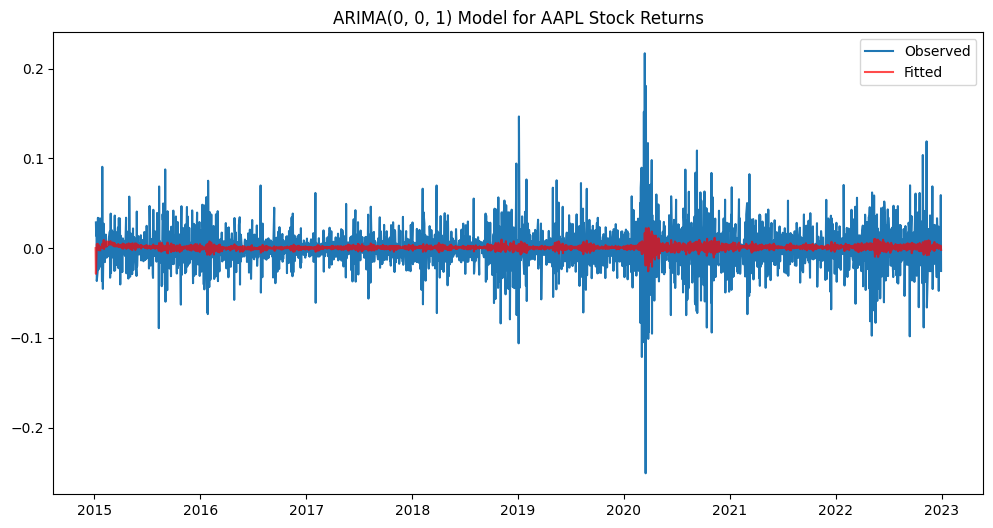

In [13]:
# Plotting the predicted vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(log_returns_diff, label='Observed')
plt.plot(arima_results.fittedvalues, color='red', label='Fitted', alpha=0.7)
plt.legend()
plt.title(f'ARIMA{best_order} Model for {stock_symbol} Stock Returns')
plt.show()

In [26]:
forecast = arima_results.forecast(steps=20)
print(forecast)


2013    0.001938
2014    0.000279
2015    0.000620
2016    0.001632
2017   -0.000492
2018    0.002382
2019   -0.000815
2020    0.002274
2021   -0.000325
2022    0.001496
2023    0.000617
2024    0.000522
2025    0.001498
2026   -0.000161
2027    0.001914
2028   -0.000280
2029    0.001745
2030    0.000131
2031    0.001164
2032    0.000793
Name: predicted_mean, dtype: float64


/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [27]:
import numpy as np

last_price = stock_data['AAPL'].iloc[-1]

price_forecast = []
current_price = last_price

for r in forecast:
    current_price = current_price * np.exp(r)
    price_forecast.append(current_price)

print(price_forecast)

forecast_df = pd.DataFrame(price_forecast,columns=["Forecast Price for next 10 days"])
forecast_df

[np.float64(128.2472332337832), np.float64(128.28299880803795), np.float64(128.36254966529586), np.float64(128.57223341844042), np.float64(128.50902646543736), np.float64(128.8154808634158), np.float64(128.71054186088466), np.float64(129.0035144460715), np.float64(128.96156897786562), np.float64(129.15467789982057), np.float64(129.23441915101859), np.float64(129.3018770869247), np.float64(129.49568540980698), np.float64(129.4747983988833), np.float64(129.72281155041057), np.float64(129.68651100006588), np.float64(129.91299429213277), np.float64(129.9299964735872), np.float64(130.08138740087165), np.float64(130.18461180418092)]


,Forecast Price for next 10 days
0,128.247233
1,128.282999
2,128.362550
3,128.572233
4,128.509026
5,128.815481
6,128.710542
7,129.003514
8,128.961569
9,129.154678


In [25]:
stock_data

Ticker,AAPL
Date,
2015-01-02,24.237545
2015-01-05,23.554737
2015-01-06,23.556963
2015-01-07,23.887281
2015-01-08,24.805082
...,...
2022-12-23,129.900284
2022-12-27,128.097504
2022-12-28,124.166786
